# Image Caption Generator using Deep Learning
This project demonstrates an image captioning model using CNN + LSTM on the Flickr8k dataset.


Import the required libraries

In [48]:
import os
# Add this line to your other imports
from nltk.translate.bleu_score import corpus_bleu
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


Load the descriptions

In [3]:
captions_path = '/content/drive/My Drive/archive/captions.txt'
images_directory = '/content/drive/My Drive/archive/Images/'

def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

captions = load_captions(captions_path)
captions[:15:3]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl climbing the stairs to her playhouse .\n',
 '1001773457_577c3a7d70.jpg,a black dog and a tri-colored dog playing with each other on the road .\n',
 '1001773457_577c3a7d70.jpg,two dogs on pavement moving toward each other .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

 Cleaning the text

In [5]:
import re

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

Cleaning the captions

In [6]:
captions_IDs = []
for i in range(len(cleaned_captions)):
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

In [ ]:
Load some images with captions

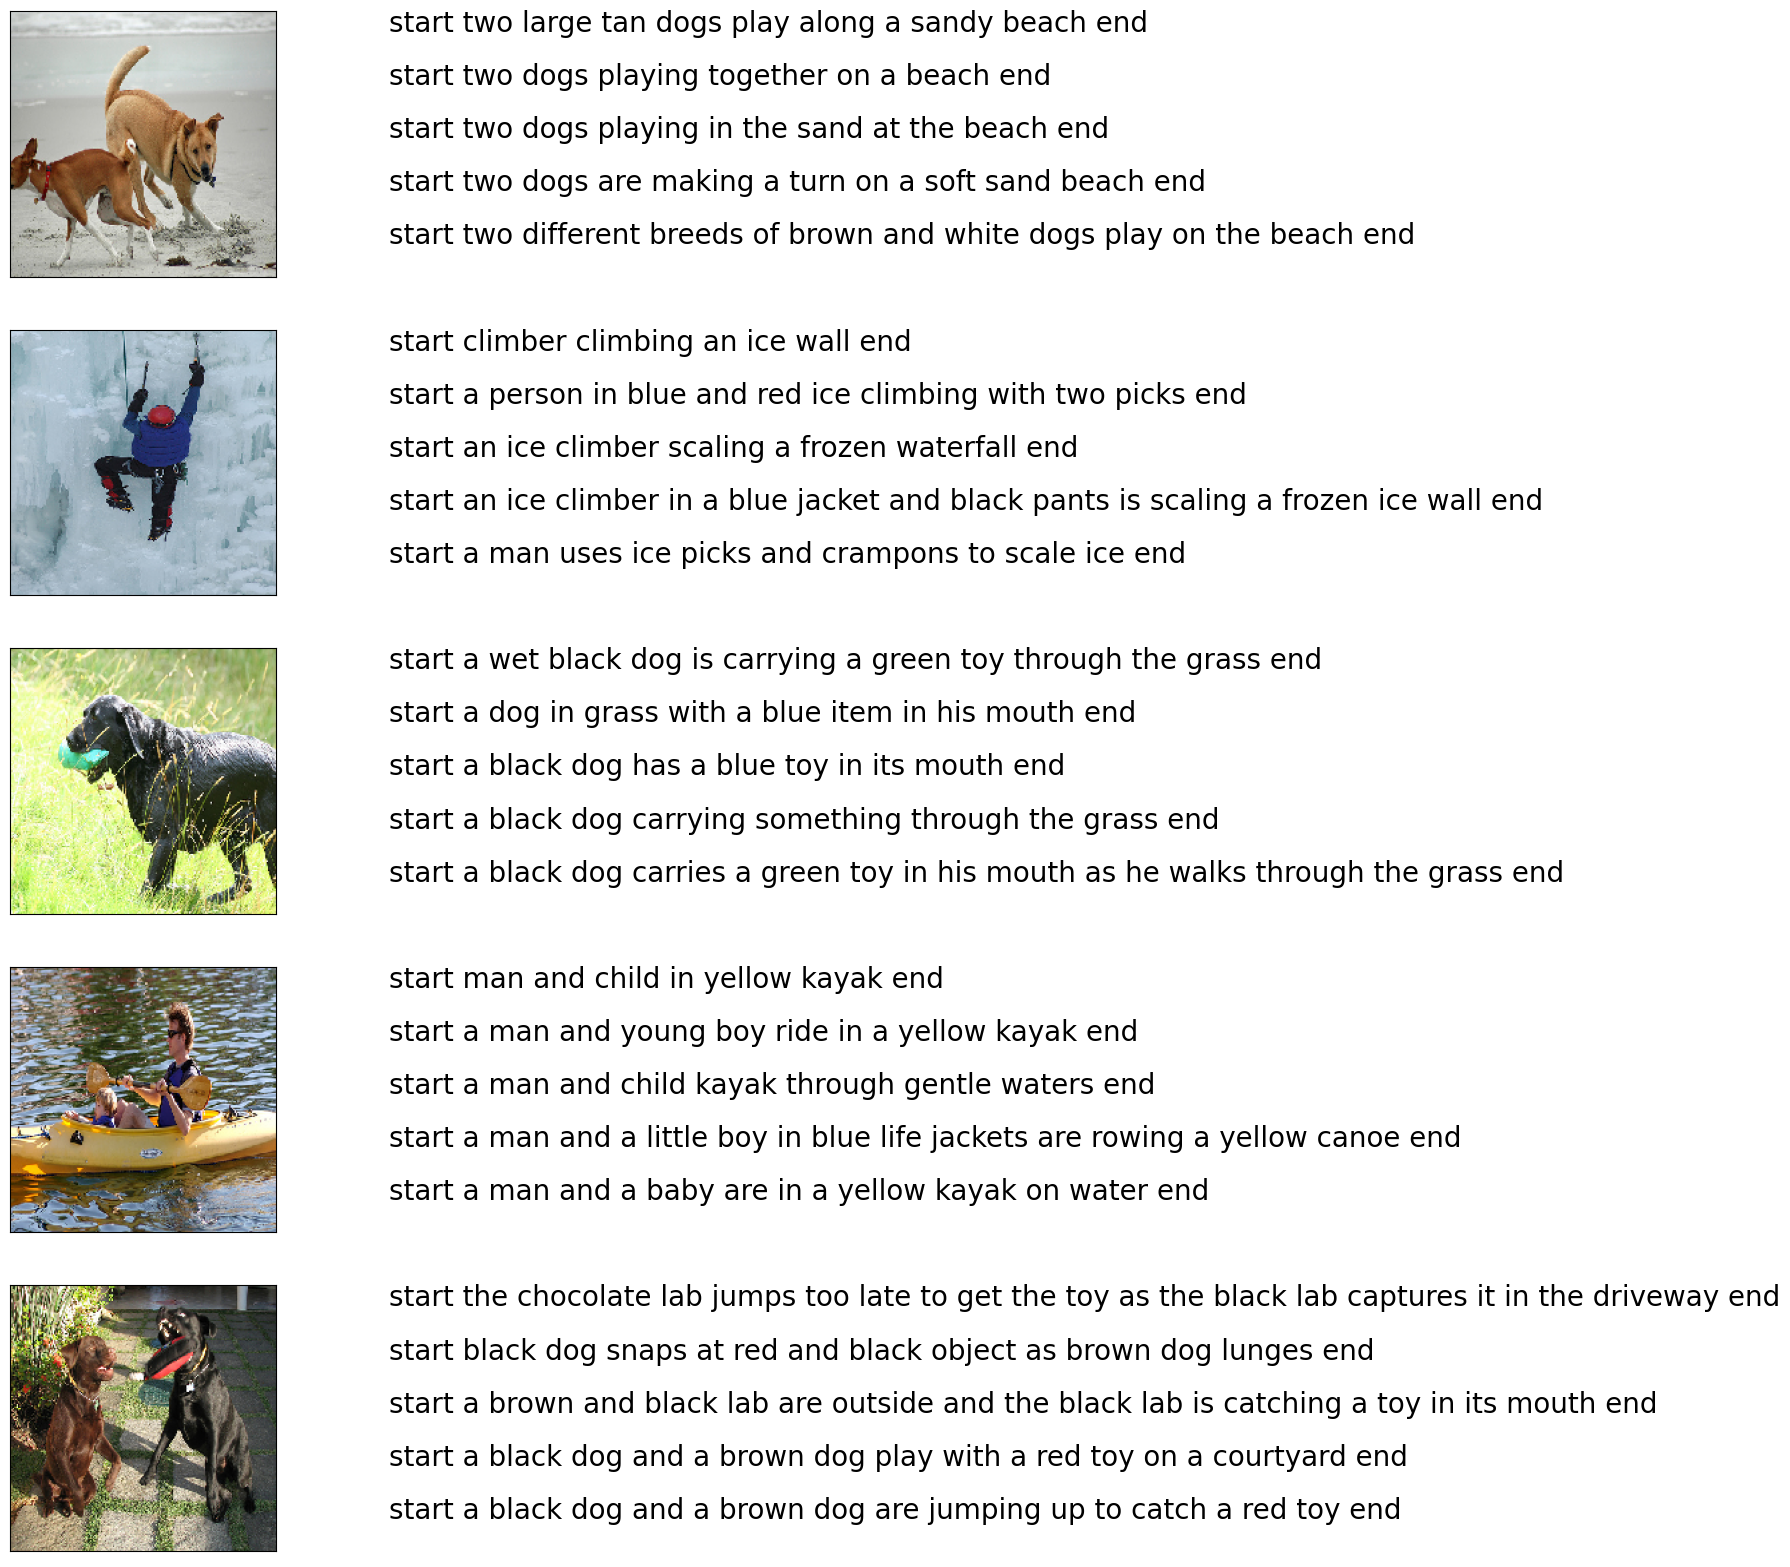

In [7]:
def visualaization(data, num_of_images):
    captions_dictionary = {}
    for item in data[100:100+(num_of_images)*5]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)
    else:
        list_captions = [x for x in captions_dictionary.items()]

    count = 1
    fig = plt.figure(figsize=(10,20))
    for filename in list(captions_dictionary.keys()):
        captions = captions_dictionary[filename]
        image_load = load_img(images_directory+filename, target_size=(199,199,3))

        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(captions))
        for i, caption in enumerate(captions):
            ax.text(0,i,caption,fontsize=20)
        count += 1
    plt.show()

visualaization(captions_IDs, 5)

Exploring the Caption Length Distribution

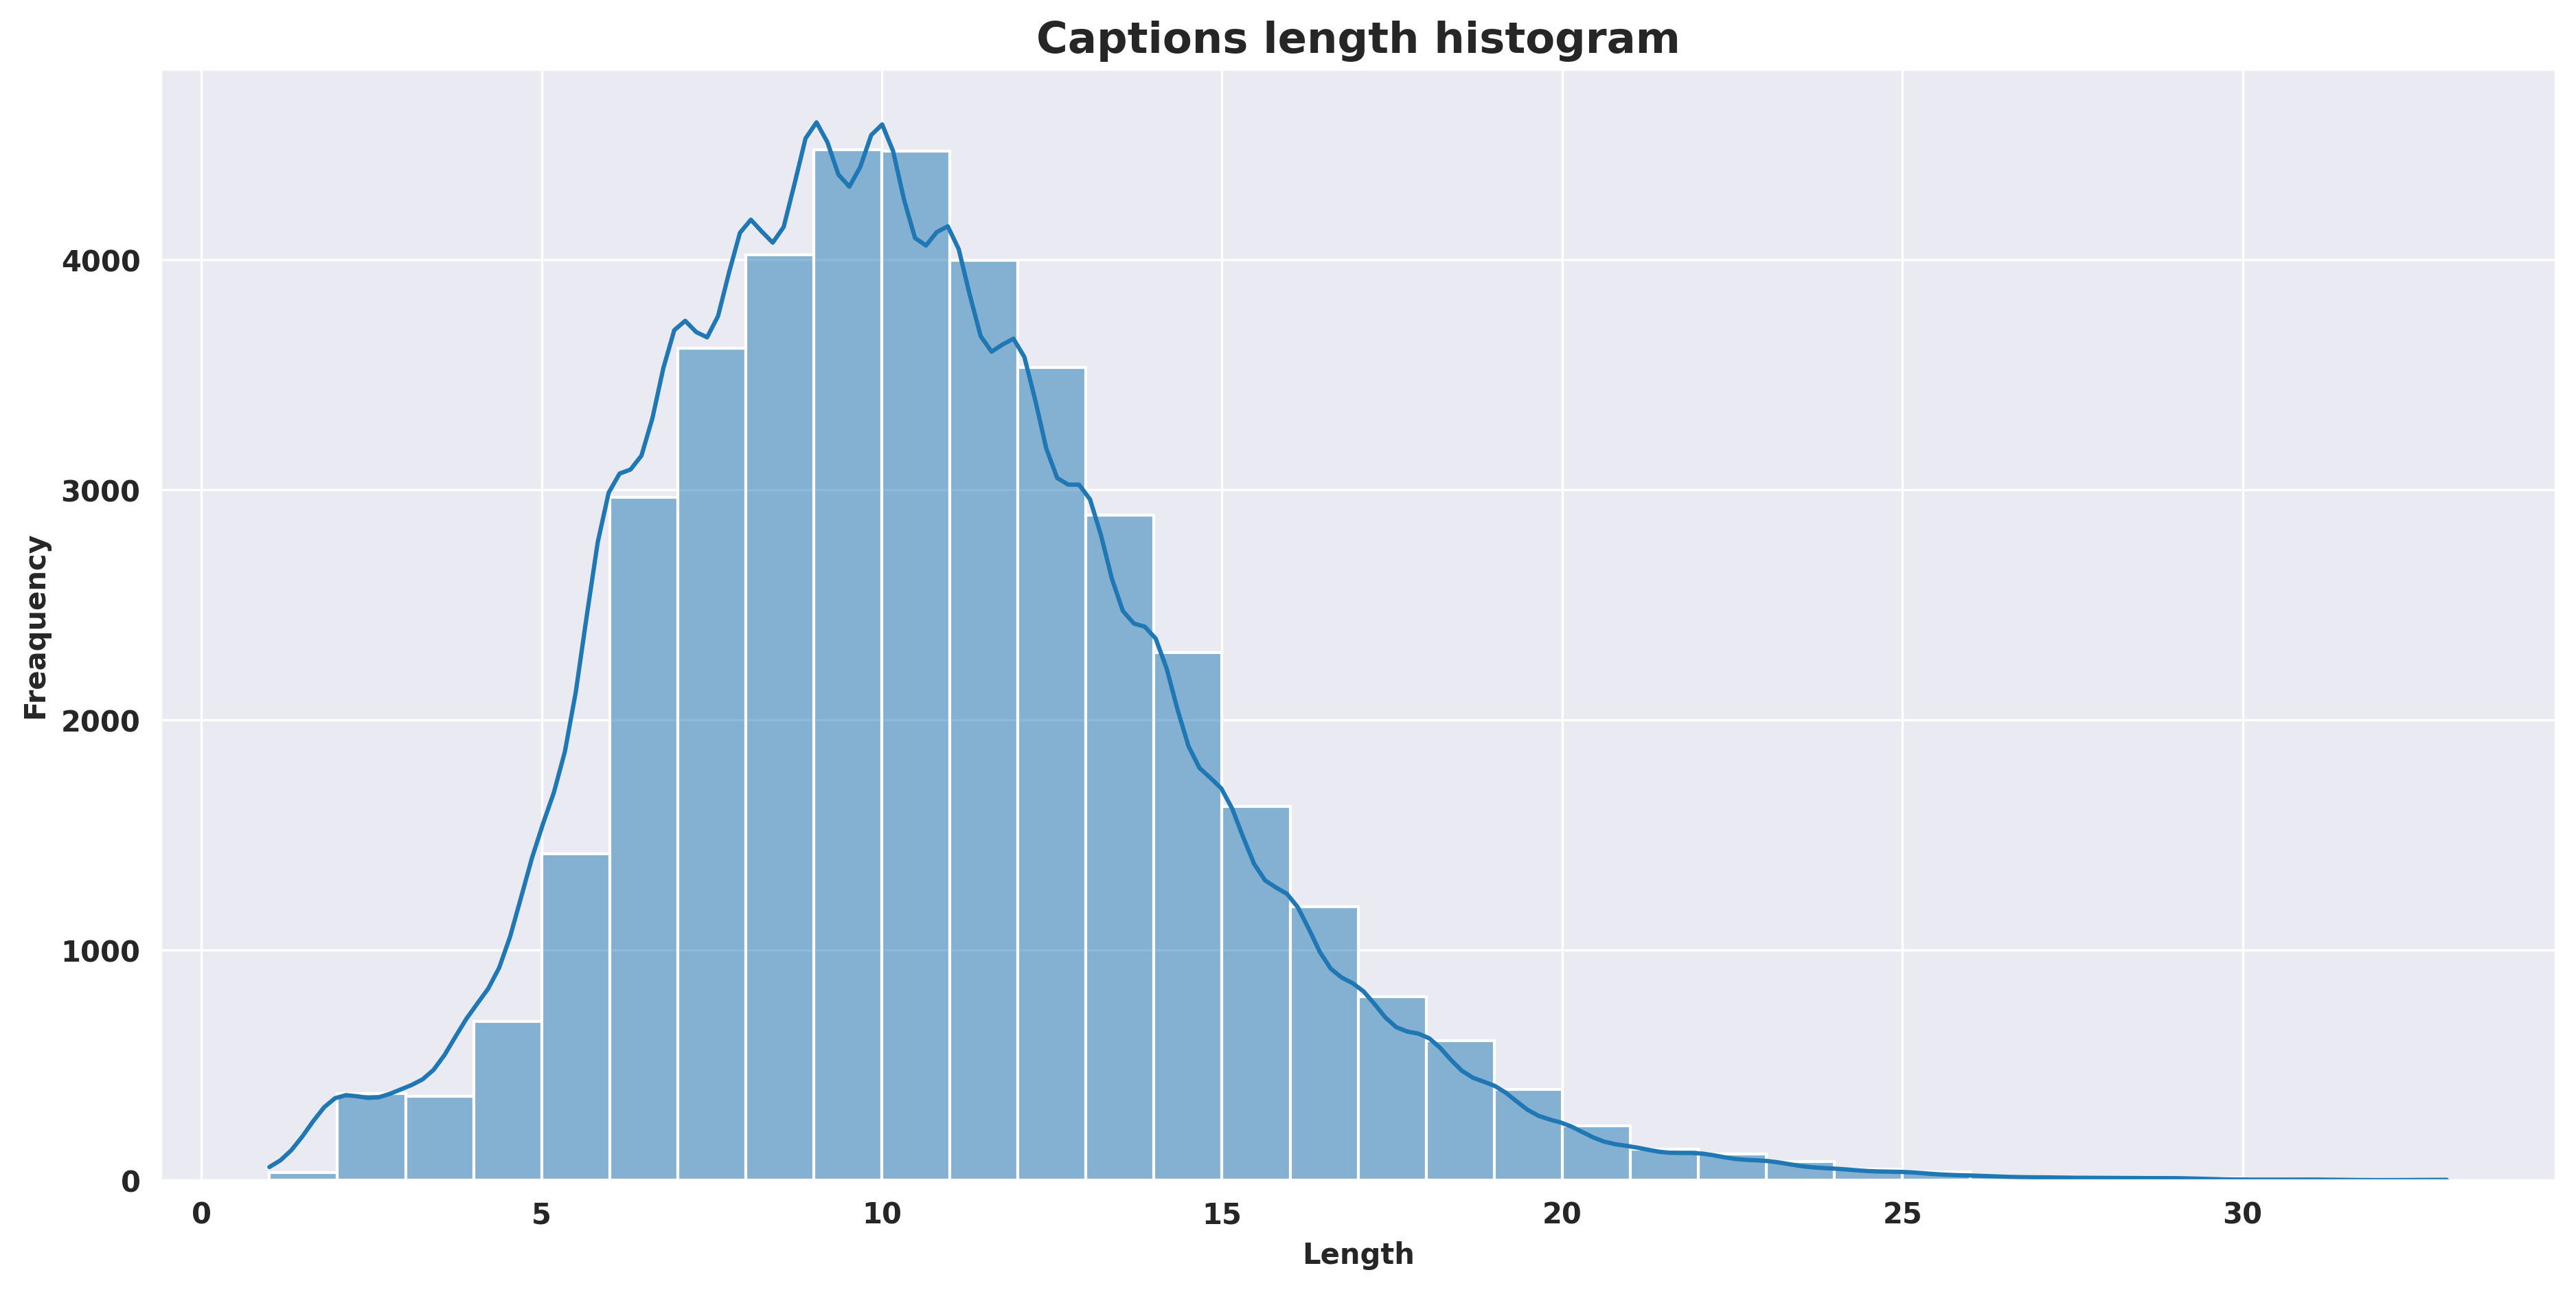

In [8]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)

Tokenizing the vocabulary

In [9]:
tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

 Splitting the data into train, validation and test sets

In [ ]:
all_image_ids = os.listdir(images_directory)

train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

 Extract the feature vector from all images

In [11]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Extracting Image Features for Training, Validation and Testing

In [12]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    else:
        print('Unknown image ID !')

pbar.close()

  0%|          | 0/2451 [00:00<?, ?it/s]

Creating a Data Generator for Model Training

In [13]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    vocab_size = len(tokenizer.word_index) + 1  
    while True:
        np.random.shuffle(image_ids)  # Shuffle for each epoch
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.strip()
                seq = tokenizer.texts_to_sequences([caption_text])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield (np.array(X_images), np.array(X_captions)), np.array(y)
            in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]




In [14]:
from tensorflow.data import Dataset
import tensorflow as tf

cnn_output_dim = inception_v3_model.output_shape[1]
vocab_size = len(tokenizer.word_index) + 1
max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1

batch_size_train = 270
batch_size_val = 150

output_signature = (
    (
        tf.TensorSpec(shape=(None, cnn_output_dim), dtype=tf.float32),
        tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32)
    ),
    tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
)

train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val),
    output_signature=output_signature
).prefetch(tf.data.AUTOTUNE)



Training the Model with Early Stopping and Learning Rate Scheduling

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.6))

lr_schedule = LearningRateScheduler(lr_scheduler)


In [18]:
# ---  MODEL DEFINITION BLOCK ---

# Define the model architecture
cnn_output_dim = 2048  # This is the output dimension from the InceptionV3 layer you used
embedding_dim = 256    # You can tune this hyperparameter
lstm_units = 256       # You can tune this hyperparameter

# Input for image features
image_input = Input(shape=(cnn_output_dim,), name='image_input')
img_features = Dropout(0.5)(image_input)
img_features = Dense(lstm_units, activation='relu', name='image_dense_layer')(img_features)

# Input for caption sequence
caption_input = Input(shape=(max_caption_length,), name='caption_input')
text_embedding = Embedding(vocab_size, embedding_dim, mask_zero=True, name='text_embedding_layer')(caption_input)
text_dropout = Dropout(0.5)(text_embedding)
text_lstm = LSTM(lstm_units, name='text_lstm_layer')(text_dropout)

# Merge the two streams
merged_layer = add([img_features, text_lstm], name='merge_layer')
decoder = Dense(lstm_units, activation='relu', name='decoder_dense_layer')(merged_layer)
output = Dense(vocab_size, activation='softmax', name='output_layer')(decoder)

# Create the final model
caption_model = Model(inputs=[image_input, caption_input], outputs=output)

# Compile the model
caption_model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

# Print a summary of the model
caption_model.summary()

# --- END OF BLOCK ---



from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

def lr_scheduler(epoch, lr):
    # A slightly less aggressive decay
    if epoch < 5:
        return float(lr)
    return float(lr * tf.math.exp(-0.2))

lr_schedule = LearningRateScheduler(lr_scheduler)

print("\n--- Starting Model Training ---")
history = caption_model.fit(
    train_dataset,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_dataset,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)
print("--- Model Training Finished ---")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ caption_input       │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_input         │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_embedding_lay… │ (None, 34, 256)   │  2,198,016 │ caption_input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 2048)      │          0 │ image_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 34, 256)   │          0 │ text_embedding_l… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 34)        │          0 │ caption_input[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_dense_layer   │ (None, 256)       │    524,544 │ dropout[0][0]     │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ text_lstm_layer     │ (None, 256)       │    525,312 │ dropout_1[0][0],  │
│ (LSTM)              │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_layer (Add)   │ (None, 256)       │          0 │ image_dense_laye… │
│                     │                   │            │ text_lstm_layer[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense_layer │ (None, 256)       │     65,792 │ merge_layer[0][0] │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 8586)      │  2,206,602 │ decoder_dense_la… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,520,266 (21.06 MB)

 Trainable params: 5,520,266 (21.06 MB)

 Non-trainable params: 0 (0.00 B)


--- Starting Model Training ---
Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 24s 491ms/step - accuracy: 0.1039 - loss: 6.7874 - val_accuracy: 0.1777 - val_loss: 5.3231 - learning_rate: 0.0010
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.1778 - loss: 5.1690 - val_accuracy: 0.2390 - val_loss: 4.7702 - learning_rate: 0.0010
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 529ms/step - accuracy: 0.2412 - loss: 4.5892 - val_accuracy: 0.2751 - val_loss: 4.3200 - learning_rate: 0.0010
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 484ms/step - accuracy: 0.2755 - loss: 4.1022 - val_accuracy: 0.3006 - val_loss: 4.0478 - learning_rate: 0.0010
Epoch 5/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 483ms/step - accuracy: 0.3057 - loss: 3.7685 - val_accuracy: 0.3207 - val_loss: 3.8484 - learning_rate: 0.0010
Epoch 6/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 490ms/step - accuracy: 0.3244 - loss: 3.5469 - val_accuracy: 0.3308 - val_loss: 3.7628 - learning_rate: 8.1873e-04
Epoch 7/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 481

In [19]:
history = caption_model.fit(
    train_dataset,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_dataset,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 18s 475ms/step - accuracy: 0.3759 - loss: 2.8746 - val_accuracy: 0.3633 - val_loss: 3.5704 - learning_rate: 1.3534e-04
Epoch 2/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 508ms/step - accuracy: 0.3843 - loss: 2.8168 - val_accuracy: 0.3650 - val_loss: 3.5737 - learning_rate: 1.3534e-04
Epoch 3/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 19s 516ms/step - accuracy: 0.3832 - loss: 2.8268 - val_accuracy: 0.3660 - val_loss: 3.5777 - learning_rate: 1.3534e-04
Epoch 4/15
38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 543ms/step - accuracy: 0.3847 - loss: 2.8080 - val_accuracy: 0.3655 - val_loss: 3.5817 - learning_rate: 1.3534e-04


 Visualizing Training and Validation Loss

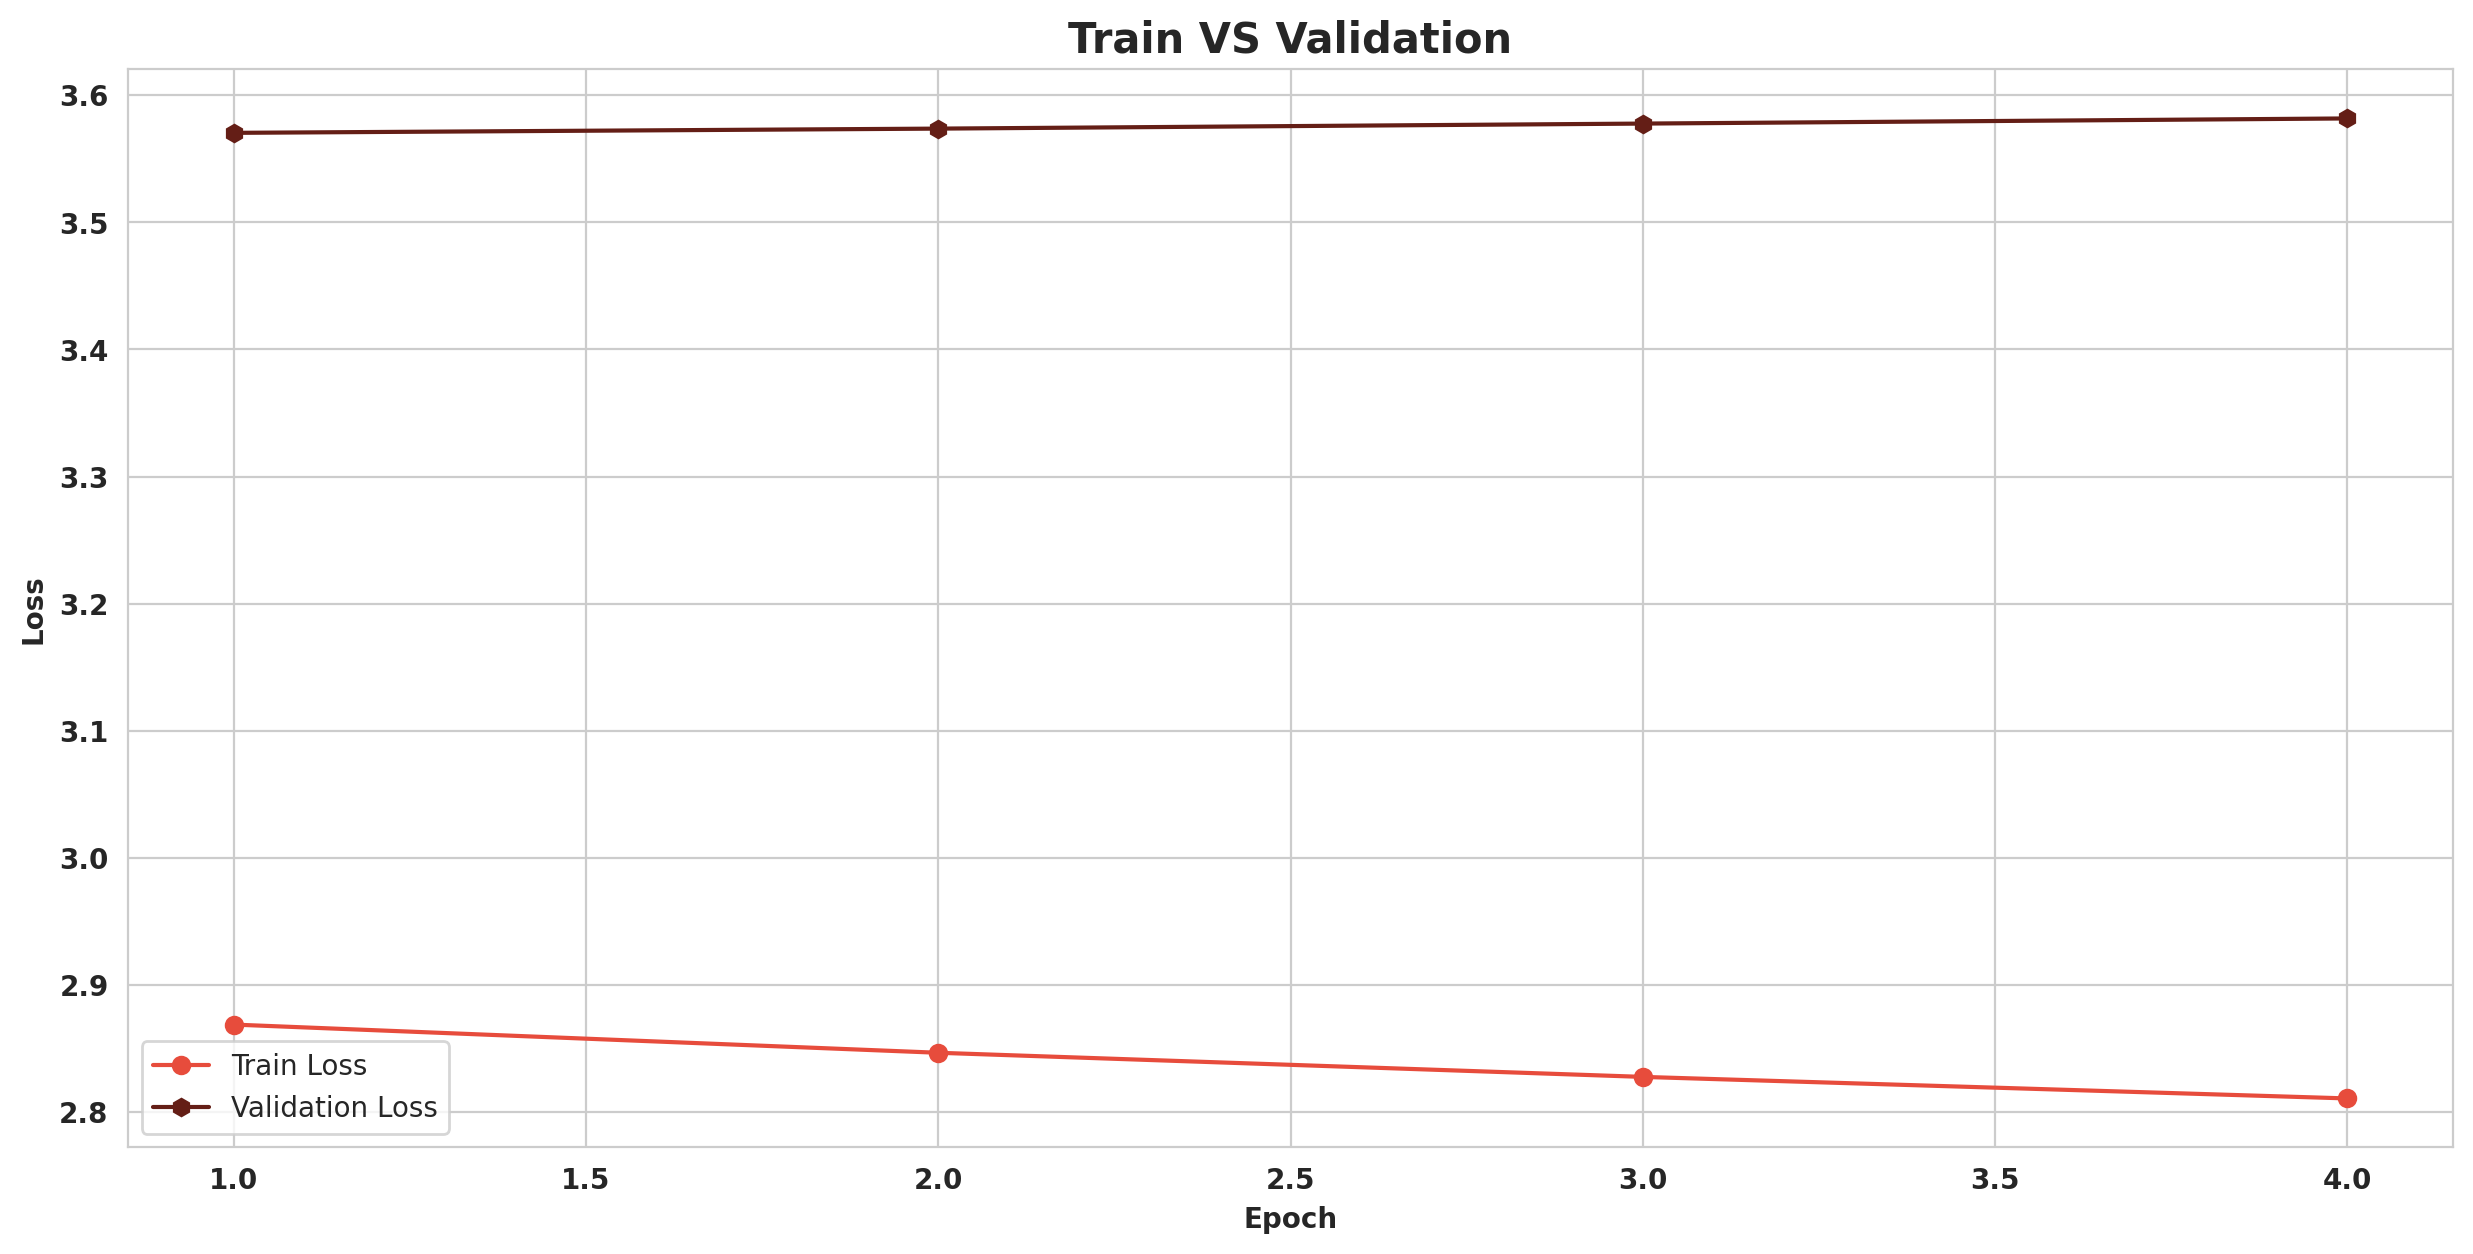

In [20]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

Generating Captions Using Greedy Search

In [39]:
def greedy_generator(image_features):
    """
    DEBUGGING version of the greedy generator.
    Prints intermediate values to find the source of the error.
    """
    print("--- Starting New Caption Generation ---")
    print(f"Vocab size being used by the generator: {vocab_size}")

    try:
        in_sequence = [tokenizer.word_index['start']]
    except KeyError:
        print("FATAL ERROR: 'start' token not found in tokenizer.word_index!")
        return "Error: 'start' token missing."

    for i in range(max_caption_length):
        print(f"\n[Loop {i+1}]")
        print(f"Current sequence of IDs: {in_sequence}")

        padded_sequence = pad_sequences([in_sequence], maxlen=max_caption_length, padding='post')

        image_input = image_features.reshape((1, -1)).astype(np.float32)
        sequence_input = padded_sequence.astype(np.int32)

        print(f"Shape of image input: {image_input.shape}, Dtype: {image_input.dtype}")
        print(f"Shape of sequence input: {sequence_input.shape}, Dtype: {sequence_input.dtype}")

        try:
            prediction = caption_model.predict([image_input, sequence_input], verbose=0)
            predicted_word_id = np.argmax(prediction)

            print(f"Model prediction successful. Predicted Word ID: {predicted_word_id}")

            # --- THIS IS THE CRITICAL CHECK ---
            if predicted_word_id >= vocab_size:
                print(f"\n\n>>> FATAL ERROR DETECTED <<<")
                print(f"The model predicted an index ({predicted_word_id}) which is OUT OF BOUNDS.")
                print(f"The vocabulary size is {vocab_size}, so the maximum valid index is {vocab_size - 1}.")
                return "Error: Model predicted an out-of-bounds index."
            # --- END OF CHECK ---

            in_sequence.append(predicted_word_id)

            predicted_word = tokenizer.index_word.get(predicted_word_id, '---UNKNOWN_ID---')
            print(f"Corresponding word: '{predicted_word}'")

            if predicted_word == 'end':
                print("'end' token predicted. Stopping generation.")
                break

        except Exception as e:
            print(f"\n\n>>> AN EXCEPTION OCCURRED DURING model.predict <<<")
            print(f"Error: {e}")
            print(f"This likely happened because the sequence passed in this loop was invalid.")
            return "Error during prediction."

    final_caption = ' '.join([tokenizer.index_word[i] for i in in_sequence[1:-1] if i in tokenizer.index_word])
    print(f"--- Final Generated Caption: {final_caption} ---")
    return final_caption

Generating Captions Using Beam Search

In [40]:
def beam_search_generator(image_features, K_beams=3, log=True):
    """
    Generates a caption for an image using the beam search algorithm.
    """
    start_token_id = tokenizer.word_index['start']
    start_word = [[[start_token_id], 0.0]]

 
    # Prepare and cast image features once.
    image_input = image_features.reshape((1, -1)).astype(np.float32)

    while len(start_word[0][0]) < max_caption_length:
        temp = []
        for s in start_word:
            sequence = pad_sequences([s[0]], maxlen=max_caption_length, padding='post')

            
            # Cast the sequence input in each loop.
            sequence_input = sequence.astype(np.int32)

            # Predict the next word probabilities.
            preds = caption_model.predict([image_input, sequence_input], verbose=0)
            # --- END OF FIX ---

            word_preds = np.argsort(preds[0])[-K_beams:]

            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += np.log(preds[0][w] + 1e-9) if log else preds[0][w]
                temp.append([next_cap, prob])

        start_word = temp
        start_word = sorted(start_word, reverse=True, key=lambda l: l[1])
        start_word = start_word[:K_beams]

        if start_word[0][0][-1] == tokenizer.word_index['end']:
            break

    best_sequence = start_word[0][0]
    final_caption = ' '.join([tokenizer.index_word[i] for i in best_sequence[1:-1] if i in tokenizer.index_word])
    return final_caption

BLEU Score

In [56]:
from nltk.translate.bleu_score import corpus_bleu

def BLEU_score(actual_captions, greedy_caption, beam_search_caption):
    """
    Calculates BLEU scores for a single generated caption against multiple references.

    - actual_captions: A list of ground-truth strings.
    - greedy_caption: A single generated string.
    - beam_search_caption: A single generated string.
    """
    # Tokenize all captions
    references = [capt.split() for capt in actual_captions]
    greedy_hyp = greedy_caption.split()
    beam_hyp = beam_search_caption.split()

    # The format for corpus_bleu is: list_of_references, hypotheses
    # For a single image, this becomes: [[ref1, ref2, ...]], [hyp1]

    # Calculate scores for Greedy Search
    score_greedy_4 = corpus_bleu([references], [greedy_hyp], weights=(0.25, 0.25, 0.25, 0.25))
    score_greedy_2 = corpus_bleu([references], [greedy_hyp], weights=(0.5, 0.5, 0, 0))

    # Calculate scores for Beam Search
    score_bs_4 = corpus_bleu([references], [beam_hyp], weights=(0.25, 0.25, 0.25, 0.25))
    score_bs_2 = corpus_bleu([references], [beam_hyp], weights=(0.5, 0.5, 0, 0))

    return [
        (f'Greedy: {greedy_caption}'),
        (f'BLEU-4 Greedy: {round(score_greedy_4, 4)}'),
        (f'BLEU-2 Greedy: {round(score_greedy_2, 4)}'),
        ("----------------------------------"),
        (f'Beam Search: {beam_search_caption}'),
        (f'BLEU-4 Beam Search: {round(score_bs_4, 4)}'),
        (f'BLEU-2 Beam Search: {round(score_bs_2, 4)}')
    ]

In [57]:
from tqdm.notebook import tqdm_notebook

Generating Captions for Test Images

In [58]:
generated_captions = {}

pbar = tqdm_notebook(total=len(test_image_features), position=0, leave=True, colour='green')
for image_id in test_image_features:
    cap = greedy_generator(test_image_features[image_id])
    generated_captions[image_id] = cap
    pbar.update(1)

pbar.close()

  0%|          | 0/37 [00:00<?, ?it/s]

--- Starting New Caption Generation ---
Vocab size being used by the generator: 8586

[Loop 1]
Current sequence of IDs: [1972]
Shape of image input: (1, 2048), Dtype: float32
Shape of sequence input: (1, 34), Dtype: int32
Model prediction successful. Predicted Word ID: 1
Corresponding word: 'a'

[Loop 2]
Current sequence of IDs: [1972, np.int64(1)]
Shape of image input: (1, 2048), Dtype: float32
Shape of sequence input: (1, 34), Dtype: int32
Model prediction successful. Predicted Word ID: 13
Corresponding word: 'black'

[Loop 3]
Current sequence of IDs: [1972, np.int64(1), np.int64(13)]
Shape of image input: (1, 2048), Dtype: float32
Shape of sequence input: (1, 34), Dtype: int32
Model prediction successful. Predicted Word ID: 6
Corresponding word: 'and'

[Loop 4]
Current sequence of IDs: [1972, np.int64(1), np.int64(13), np.int64(6)]
Shape of image input: (1, 2048), Dtype: float32
Shape of sequence input: (1, 34), Dtype: int32
Model prediction successful. Predicted Word ID: 13
Corresp

In [44]:
print(f"Vocab size: {vocab_size}")
print(f"Max caption length: {max_caption_length}")

Vocab size: 8586
Max caption length: 34


In [49]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [54]:
import os
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

from nltk.translate.bleu_score import corpus_bleu # <--- ADD THIS LINE

# ... rest of  imports
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
# etc.

 Visualizing Caption Generation Results


--- About to call the visualization function ---
>>> 1. ENTERED the visualization function.
>>> 2. The data dictionary has 37 items. It is not empty.
>>> 3. Randomly selected 7 images to display: [np.str_('233242340_09963100a3.jpg'), np.str_('124881487_36e668145d.jpg'), np.str_('2172526745_649f420569.jpg'), np.str_('232874193_c691df882d.jpg'), np.str_('2599131872_65789d86d5.jpg'), np.str_('2532262109_87429a2cae.jpg'), np.str_('2599131872_65789d86d5.jpg')]
>>> 4. Created a Matplotlib figure. Starting the loop...
>>> 5. INSIDE THE LOOP. Processing image: 233242340_09963100a3.jpg
>>> 5. INSIDE THE LOOP. Processing image: 124881487_36e668145d.jpg
>>> 5. INSIDE THE LOOP. Processing image: 2172526745_649f420569.jpg
>>> 5. INSIDE THE LOOP. Processing image: 232874193_c691df882d.jpg
>>> 5. INSIDE THE LOOP. Processing image: 2599131872_65789d86d5.jpg
>>> 5. INSIDE THE LOOP. Processing image: 2532262109_87429a2cae.jpg
>>> 5. INSIDE THE LOOP. Processing image: 2599131872_65789d86d5.jpg
>>> 6. FI

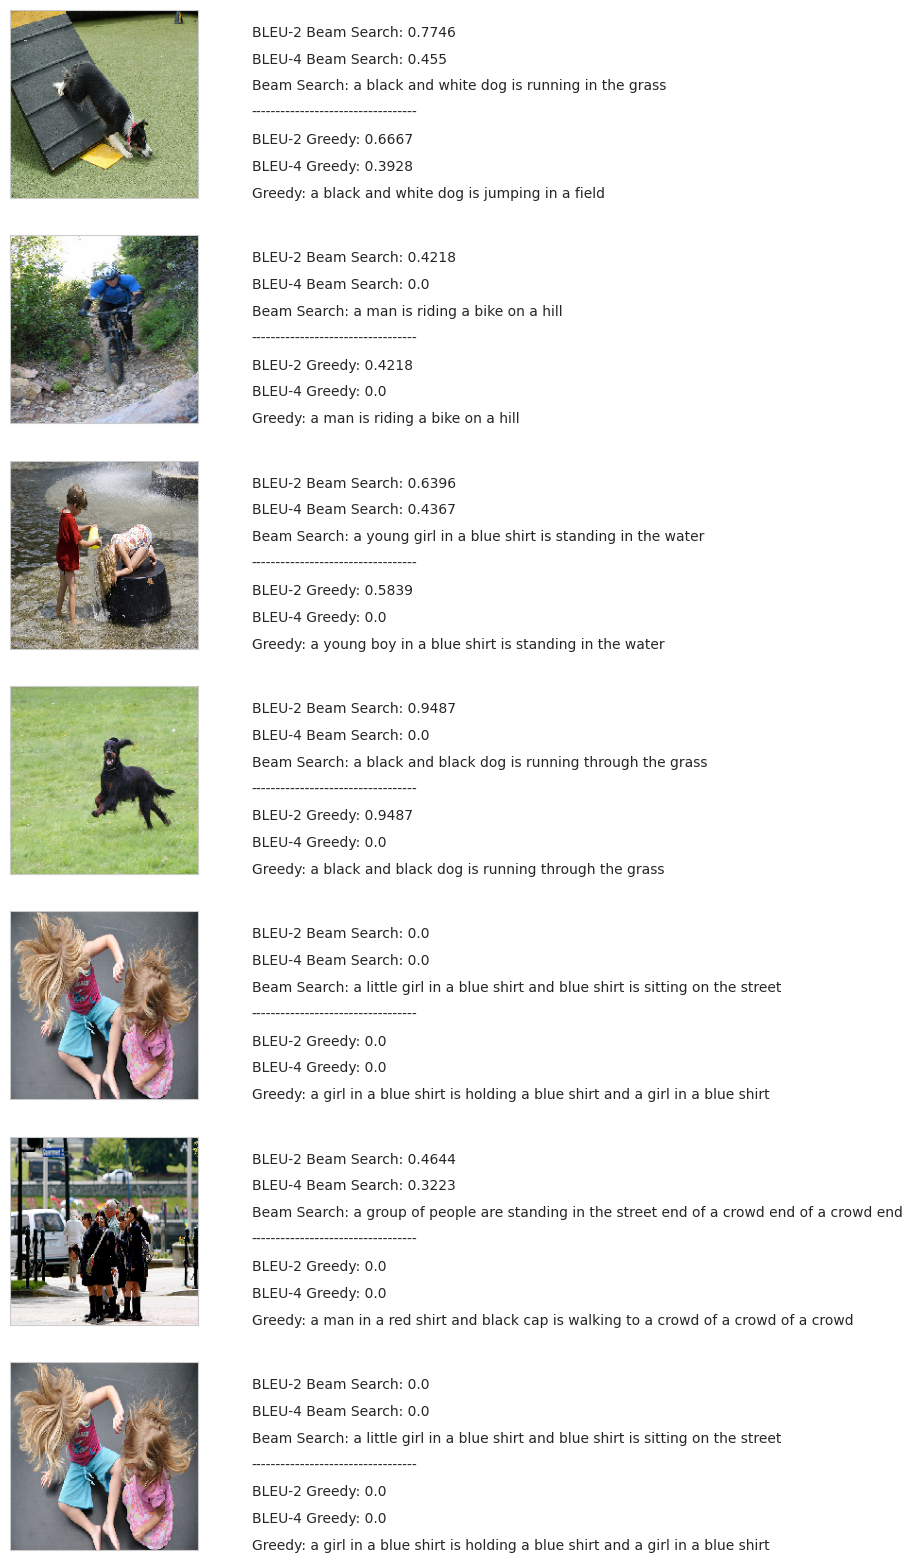

--- Finished calling the visualization function ---



In [70]:


# ===================================================================
def visualization(data, greedy_caps, beamS_generator, evaluator, num_of_images):
    print(">>> 1. ENTERED the visualization function.")

    
    if not data:
        print(">>> FATAL ERROR: The `data` (test_actual_captions) dictionary is EMPTY. Nothing to display.")
        return 

    print(f">>> 2. The data dictionary has {len(data)} items. It is not empty.")

    keys = list(data.keys())
    images = [np.random.choice(keys) for i in range(num_of_images)]

    print(f">>> 3. Randomly selected {len(images)} images to display: {images}")

    count = 1
    fig = plt.figure(figsize=(6,20))
    print(">>> 4. Created a Matplotlib figure. Starting the loop...")

    # The main loop
    for filename in images:
        print(f">>> 5. INSIDE THE LOOP. Processing image: {filename}")

        actual_cap = data[filename]
        greedy_cap = greedy_caps[filename]
        beamS_cap = beam_search_generator(test_image_features[filename])
        caps_with_score = evaluator(actual_cap, greedy_cap, beamS_cap)

        image_load = load_img(images_directory+filename, target_size=(199,199,3))
        ax = fig.add_subplot(num_of_images,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        ax = fig.add_subplot(num_of_images,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,len(caps_with_score))
        for i, text in enumerate(caps_with_score):
            ax.text(0,i,text,fontsize=10)
        count += 1

    print(">>> 6. FINISHED the loop.")
    print(">>> 7. About to call plt.show() to display the final plot.")
    plt.show()



# ===================================================================
print("\n--- About to call the visualization function ---")

visualization(test_actual_captions, generated_captions, beam_search_generator, BLEU_score, 7)
print("--- Finished calling the visualization function ---\n")